In [25]:
import numpy as np
import pandas as pd
import heapq
import matplotlib.pyplot as plt
import time
import contextily as ctx
import math
import random
import heapdict

from collections import defaultdict
from tqdm import tqdm



## 2.3.1

In [26]:
df_edges = pd.read_csv("edges.tsv", sep="\t")
df_nodes = pd.read_csv("nodes.tsv", sep="\t")
print(df_edges.head())
print(df_nodes.head())

          u           v       length            name
0  12885866    12885923    18.992015      Hlíðartorg
1  12885866  1573411414   653.666145  Reykjanesbraut
2  12885876  1660480490    35.437064      Flatahraun
3  12885876    12885952    16.131272         FH-Torg
4  12885922  2978379988  2587.067864  Reykjanesbraut
      osmid          x          y  primary
0  12885866 -21.937473  64.067271    False
1  12885876 -21.939951  64.076157     True
2  12885922 -22.087890  64.031977    False
3  12885923 -21.937852  64.067260    False
4  12885924 -21.938078  64.067047     True


## 2.3.2

In [27]:
def preprocess_data(df_edges, df_nodes):
    # Create node dictionary with all attributes
    node_dict = {
        row['osmid']: {
            'osmid': row['osmid'],
            'x': row['x'],
            'y': row['y'],
            'primary': row['primary']
        }
        for _, row in df_nodes.iterrows()
    }
    
    # Create enhanced adjacency list with original edge data
    adjacency_list = defaultdict(list)
    for _, edge in tqdm(df_edges.iterrows()):
        adjacency_list[edge['u']].append({
            'u': edge['u'],
            'v': edge['v'],
            'length': edge['length'],
            'name': edge['name']
        })
    
    return node_dict, adjacency_list

# Gets edge between nodes u and v
def get_edge(u, v, adjacency_list):
    return [edge for edge in adjacency_list.get(u['osmid'], []) if edge['v'] == v['osmid']]

# Gets outgoining edges from node u
def get_out_roads(u, adjacency_list):
    return adjacency_list.get(u['osmid'], [])

# Gets all edges that u has edges to
def get_neighbors(u, node_dict, adjacency_list):
    neighbors = []
    for edge in adjacency_list.get(u['osmid'], []):
        neighbor_osmid = edge['v']
        if neighbor_osmid in node_dict:
            neighbors.append(node_dict[neighbor_osmid])
    return neighbors

In [28]:
node_dict, adjaceny_list = preprocess_data(df_edges, df_nodes)

22319it [00:00, 31765.36it/s]


In [29]:
# Input: 
#   -start_point: numpy array[osmid, x, y, primary]
#   -end_point: numpy array[osmid, x, y, primary]
#
# Returns: 
#   -distance: dictionary þar sem distance[i] er fjarlægð node[i] frá start_point
#   -prev_edge: dictionary af edges

def dijkstra(start_point, threshold=None, nodes=node_dict, edges=adjaceny_list):
    prev_edge = {osmid: None for osmid in node_dict}
    distance = {osmid: float("inf") for osmid in node_dict}
    distance[start_point['osmid']] = 0
    heap = heapdict.heapdict()
    heap[start_point['osmid']] = 0

    while heap:
        u, current_distance = heap.popitem()
        u = nodes[u]
        if threshold and current_distance > threshold:
            continue  

        for v in get_neighbors(u, nodes, edges):
            current_edges =  get_edge(u, v, edges)
            for current_edge in current_edges:
                if current_distance + current_edge['length'] < distance[v['osmid']]: 
                    distance[v['osmid']] = current_distance + current_edge['length']
                    prev_edge[v['osmid']] = current_edge
                    heap[v['osmid']] = distance[v['osmid']]

    return distance, prev_edge

In [30]:
# Leitar að stystu leið frá upphafs staðsetningum í loka staðsetningarnar.
# Ef lokastaðsetningar eru ekki skilgreindar þá leitar það stystu leið í alla punkta. 
#
# Input:
#   -starting_points: numpy array af numpy arrays [osmid, x, y, primary]
#   -end_points: optional pandas dataframe af nodes
#
# Returns: numpy array af dictionaries {station, distances, edges} stundum kallað paths af mér
def leit(starting_points, end_points=None):
    results = []
    for node in starting_points:
        dist, prev_edge = dijkstra(node)
        results.append( { "start_position": node, "distances": dist, "edges": prev_edge })

    return np.array(results)

## 2.3.3

In [31]:
# Input: 
#   -paths: Dictinoary {distances, edges} 
#   -stations: List of stations.
# 
# Returns: 
#   -nearest_station_id: int 
#   -shortest_distance: float,
#   -shortest_path: List[edges]
def find_closest_station(paths, stations):
    distances = paths["distances"]
    backtracking_paths = paths["edges"]

    nearest_station_id = min(stations["osmid"].tolist(), key=lambda k: distances[k])

    shortest_distance = distances[nearest_station_id]

    shortest_path = []
    current_position = nearest_station_id
    while distances[current_position] > 0:
        road = backtracking_paths[current_position]
        shortest_path.append(road)
        current_position = road["u"]

    return nearest_station_id, shortest_distance, shortest_path

In [32]:
def sample(n):
    random_osmids = random.sample(list(node_dict.keys()), k=n)
    return [node_dict[osmid] for osmid in random_osmids]

In [33]:
start_points = sample(5)
end_points = sample(5)
           
starting_position_paths = leit(start_points, end_points)

In [34]:
# Input:
#   -start_point: np array [osmid, x, y, primary]
#   -dictionary osmid as key and  edges [u, v, length, name] as values
#   -dictionary osmid as key and distances as values
#
def construct_path(end_point, prev_edges, distances, nodes=node_dict):
    path =[]
    point = end_point
    path.append([point['x'], point['y']])
    while (distances[point['osmid']] > 0):
        point = nodes[prev_edges[point['osmid']]['u']]
        path.append([point['x'], point['y']])
    path = np.array(path)
    return path


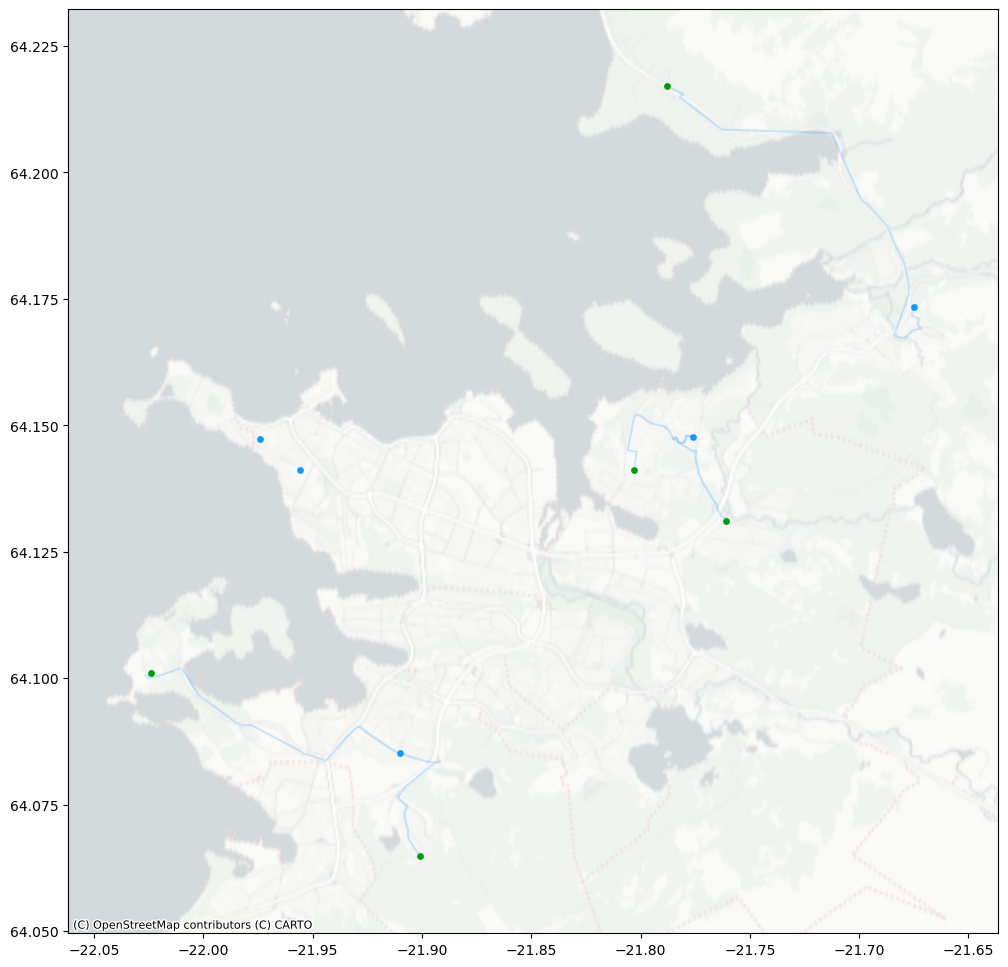

In [35]:
def draw_paths(start_points, end_points , paths):
    fig, ax = plt.subplots(figsize=(12, 12))

    all_x, all_y = [], []
    for path in paths:
        ax.plot(path[:, 0],path[:, 1], c='#1099ff', alpha=0.2)
        all_x.extend(path[:, 0])
        all_y.extend(path[:, 1])



    start_x = [node['x'] for node in start_points]
    start_y = [node['y'] for node in start_points]
    end_x = [node['x'] for node in end_points]
    end_y = [node['y'] for node in end_points]
    ax.scatter(end_x, end_y, c='#1099ff', s=15, alpha=1)
    ax.scatter(start_x, start_y, c='#009900', s=15, alpha=1)

    all_x += start_x + end_x
    all_y += start_y + end_y

    # Calculate data bounds with a 10% buffer
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    buffer_x = (max_x - min_x) * 0.1  # 10% buffer
    buffer_y = (max_y - min_y) * 0.1

    # Set axis limits to zoom out
    ax.set_xlim(min_x - buffer_x, max_x + buffer_x)
    ax.set_ylim(min_y - buffer_y, max_y + buffer_y)

    # Add basemap with a lower zoom level (e.g., zoom=10)
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.PositronNoLabels, zoom="auto")

    plt.show()



starting_position_paths = leit(start_points, end_points)
paths = []
for path in starting_position_paths:
    distances = path['distances']
    prev_edge = path['edges']
    
    nearest_station = min(end_points, key=lambda k: distances[k['osmid']])
    paths.append(construct_path(nearest_station ,prev_edge, distances))

draw_paths(start_points, end_points, paths)


## 2.3.4

In [36]:
start = time.time()
leit(end_points)
end = time.time()
print("time:", end- start)

time: 0.2689998149871826


## 2.3.5

In [ ]:
# Estimate-ar kostnað/distance milli nodes u og v
#
# Input:
#   -u: numpy array[osmid, x, y, primary]
#   -v: numpy array[osmid, x, y, primary]
#
# Returns:
#   -distance: distance by airplane between the two points
def estimate_function(u, v):
    xu, yu = u['x'], u['y']
    xv, yv = v['x'], v['y']
    return math.sqrt((xu - xv)**2 + (yu - yv)**2)


# Input:
#   -start_point: numpy array[osmid, x, y, primary]
#   -end_point: numpy array[osmid, x, y, primary]
def A_star(start_point, end_point, nodes=node_dict, edges = adjaceny_list):

    prev_edge = {osmid: None for osmid in node_dict}
    g_score = {osmid: float("inf") for osmid in node_dict}
    f_score = {osmid: float("inf") for osmid in node_dict}

    heap = heapdict.heapdict()

    g_score[start_point['osmid']] = 0
    f_score[start_point['osmid']] = estimate_function(start_point, end_point)

    heap[start_point['osmid']] = f_score[start_point['osmid']]
    while heap: 
        u, current_f_score = heap.popitem()
        u = nodes[u]

        if u['osmid'] == end_point['osmid']:
            return construct_path(u, prev_edge, g_score), g_score[u['osmid']]

        neighbors = get_neighbors(u, nodes, edges)

        for neighbor in neighbors:
           roads = get_edge(u, neighbor, edges)

           for road in roads:
                road['length']
                temp_gscore = g_score[u['osmid']] + road['length'] 
                if temp_gscore < g_score[neighbor['osmid']]:
                    prev_edge[neighbor['osmid']] = road
                    g_score[neighbor['osmid']] = temp_gscore
                    f_score[neighbor['osmid']] = temp_gscore + estimate_function(neighbor, end_point)
                    
                    heap[neighbor['osmid']] = f_score[neighbor['osmid']]
    return None

In [38]:
start_points = sample(5) 
end_points = sample(5)

Average time: 0.04020012855529785
Average time dijkstra 0.06119914054870605


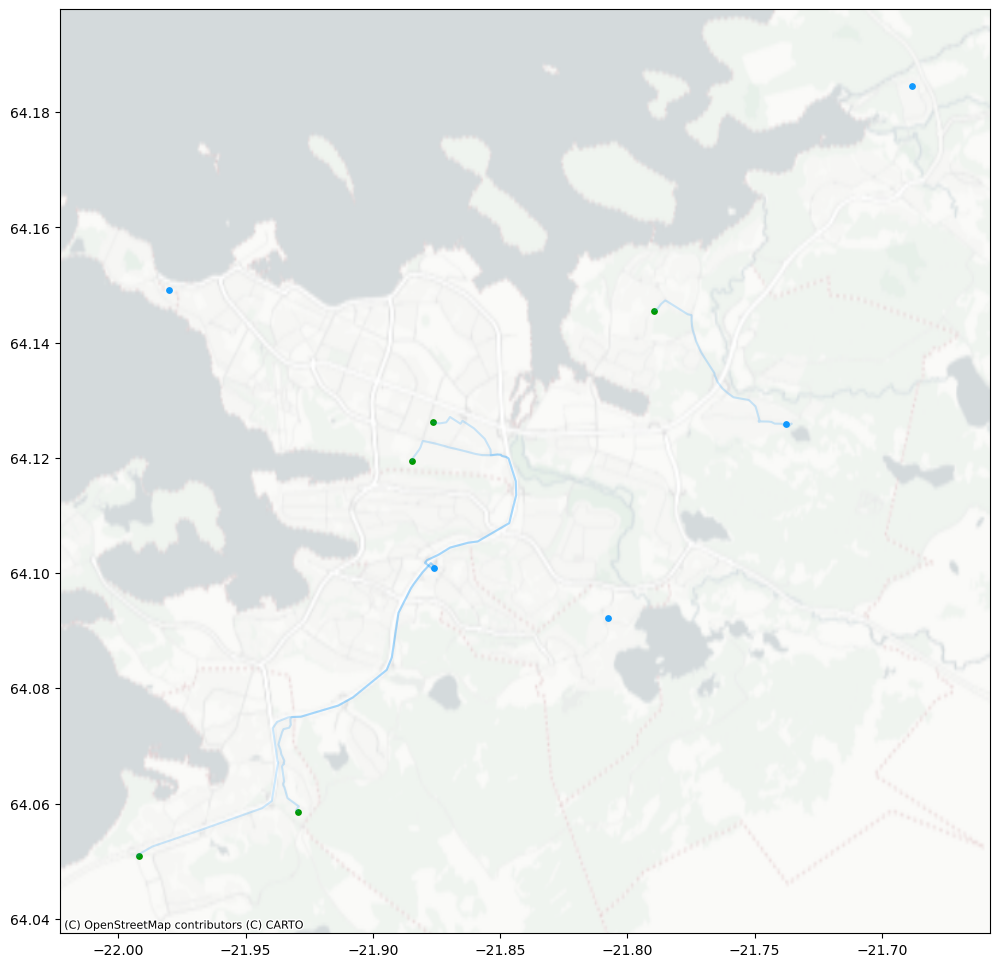

In [39]:
results = []

times = [[],0]
times_d = [[], 0]
for start in start_points:
    min_distance = float('inf')
    optimal_path = None
    start_time = time.time()
    dijkstra(start)
    end_time = time.time()
    times_d[0].append(end_time - start_time)
    times_d[1] += 1
    
    for end in end_points:
        start_time = time.time()
        path, distance = A_star(start, end)
        end_time = time.time()
        times[0].append(end_time - start_time)
        times[1] += 1

        if distance < min_distance:
            min_distance = distance
            optimal_path = path
    
    if min_distance != float('inf'):
        results.append(optimal_path)
all_times = np.array(times[0])
all_times_d = np.array(times_d[0])
print("Average time:", np.sum(all_times)/times[1])
print("Average time dijkstra", np.sum(all_times_d)/times_d[1])
draw_paths(start_points, end_points, results)

In [40]:
# Þetta fall tekur um 6 mín
#
# Returns:
#   -distances: dict þar sem distances[(start, end)] er fjarlægð frá start til end. 
def preprocess_distances(end_points, nodes=node_dict):
    distances = {}
    for start in tqdm(nodes.values(), desc="Processing nodes"): 
        current_distance, _ = dijkstra(start)
        for end in end_points:
            distances[(start['osmid'], end['osmid'])] = current_distance[end['osmid']]
    return distances

def get_end_points(sample_size=0, nodes=node_dict):
    primary_nodes = df_nodes.query("primary == True")
    primary_nodes_osmid = primary_nodes['osmid'].to_numpy()
    end_points = np.array([nodes[i] for i in primary_nodes_osmid])
    if sample_size == 0:
        return end_points


In [41]:
def cost_function(distances):
    return sum(d if d != float('inf') else 1e9 for d in distances.values())

In [42]:
# Input:
#   -original_adj: adjacency matrix
# 
# Returns: sama adjacency matrix nema búið að snúa við leggjunum
def reverse_adjacency_list(original_adj):
    reversed_adj = defaultdict(list)
    for src_node in original_adj:
        for edge in original_adj[src_node]:
            reversed_edge = {
                'u': edge['v'],  
                'v': edge['u'],  
                'length': edge['length'],
                'name': edge['name']
            }
            reversed_adj[reversed_edge['u']].append(reversed_edge)
    
    return reversed_adj

In [43]:
# Input:
#   -A: dictionary af distances
#   -B: dictionary af distances
#
# Returns:
#   -final_dict: þar sem fyrir hvert i er final_dict[i] = min(A[i], B[i])
def combine_dicts_min(A, B):
    if B is None:
        return A
    common_keys = set(A.keys()) & set(B.keys())
    final_dict = {osmid: min(A[osmid], B[osmid]) for osmid in common_keys}
    return final_dict

# Input:
#   -end_points: list of all end_points
#
# Returns:
#   -end_dist: dictionary of distance dictionaries
def get_end_dist(end_points, edges=adjaceny_list):
    end_dist = {end_point['osmid']: None for end_point in end_points}
    for end_point in tqdm(end_points):
        dist_current, _= dijkstra(end_point, edges=edges)
        end_dist[end_point['osmid']] = dist_current
    return end_dist

# Finds best end_point so that the sum of all distances from each point to each of the chosen end_points is minimized. 
# (ég honestly zone-aði smá út þegar ég skrifaði þetta comment svo ekki pæla of mikið í því)
#
# Input:
#   -end_points: all available end_points
#   -best_dist: distance dictionary for all of the chosen end points. (None if no end_point has been chosen)
#   -and_dist: distance dictionary of all end points
#
# Returns:
#   -best_end: optimal end point
#   -current_best_dist: basically bara það sem best_dist verður sett sem fyrir næsta iteration.
def get_best_end_point(end_points, best_dist, end_dist):
    best_cost = float('inf')
    best_end = None
    current_best_dist = None
    for end_point in end_points:
        dist_current = end_dist[end_point['osmid']]
        combined_dist = combine_dicts_min(dist_current, best_dist)
        cost = cost_function(combined_dist)
        if cost < best_cost:
            best_end = end_point
            best_cost = cost
            current_best_dist = combined_dist
    return best_end, current_best_dist
    


In [44]:
end_points = get_end_points()
reversed_edges = reverse_adjacency_list(adjaceny_list)
end_dist  = get_end_dist(end_points, edges=reversed_edges)

100%|██████████| 1829/1829 [01:41<00:00, 17.95it/s]


In [45]:
# Input
#   -k: hversu margar hleðslustöðvar
#   -end_points: allar mögulegar staðsetningar fyrir hleðslustöðvar
# 
# Returns:
#   -best_ends: Listi af bestu hleðslustöðvum
#   -best_dist: dictinoary þar sem best_dist[i] er fjarlægð node[i] frá næstu hleðslustöð
def best_placement(k, end_points=end_points, end_dist = end_dist, edges=reversed_edges):
    best_ends = []
    best_dist = None
    if end_dist is None:
        end_dist = get_end_dist(end_points, edges=edges)

    for _ in tqdm(range(k)):
        best_end, current_best_dist = get_best_end_point(end_points, best_dist, end_dist)
        best_ends.append(best_end)
        best_dist = current_best_dist
    return best_ends, best_dist

In [46]:
one_point, _ = best_placement(1) 
ten_points, _ = best_placement(10)

100%|██████████| 10/10 [01:22<00:00,  8.24s/it]


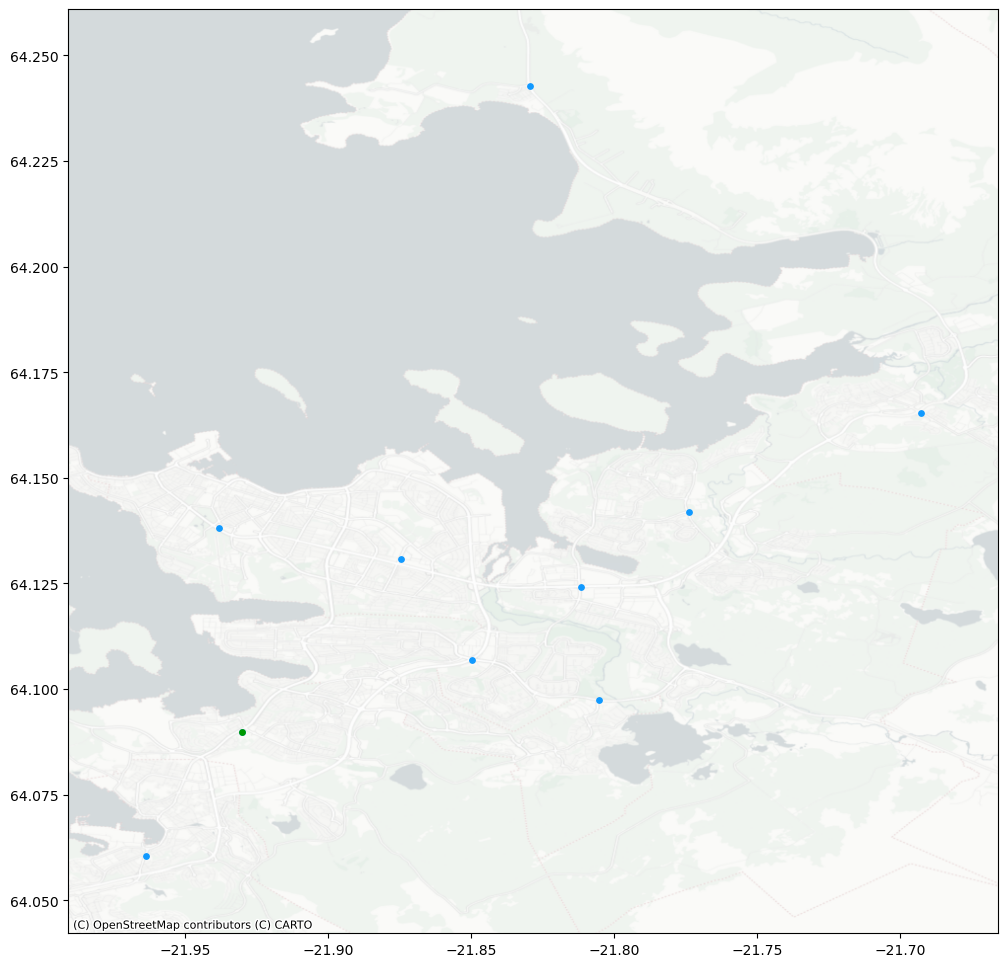

In [47]:
draw_paths(one_point, ten_points, [])

In [48]:
def get_two_end_points(end_points, best_dist=None, end_dist=end_dist):
    heap = heapdict.heapdict()
    for end_point in end_points:
        dist_current = end_dist[end_point['osmid']]
        combined_dist = combine_dicts_min(dist_current, best_dist)
        cost = cost_function(combined_dist)
        heap[end_point['osmid']] = cost